In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import random
import shutil
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!pip install split-folders
import splitfolders

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

print(f"TensorFlow version: {tf.__version__}")

--2023-12-25 13:40:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-25 13:40:45 (41.4 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]

TensorFlow version: 2.15.0


In [7]:
!nvidia-smi

Mon Dec 25 13:40:45 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%cd '/content/drive/MyDrive/Fish dataset'
!unrar x Fish-Pak.rar

[Errno 2] No such file or directory: '/content/drive/MyDrive/Fish dataset'
/content

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal

Cannot open Fish-Pak.rar
No such file or directory
No files to extract


In [10]:
path = "/content/drive/MyDrive/Haram Fish dataset"
print(os.listdir(path))

['Fish-Pak.rar', 'red mulla.jpg', 'Fish-Pak', 'Fish_Splitted', 'model_trained_aun', 'model_2.h5', 'model_3', 'your_image.png', 'your_image.jpg', 'Silver-Body (11).JPG', 'Silver-Body (15).JPG', 'Silver-Body (1).JPG', 'Silver-Body (14).JPG', 'test fishes', 'New Aun gone market', 'Aun Self Dataset Separated', 'Fish_Splitted_Self', '.index', '.data-00000-of-00001', 'checkpoint', 'Haram Models & Weights_AUN']


In [11]:
input_folder = '/content/drive/MyDrive/Fish dataset/Fish-Pak'

splitfolders.ratio(input_folder, output="/content/drive/MyDrive/Fish dataset/Fish_Splitted",
                   seed=42, ratio=(.7, .0, .3),
                   group_prefix=None)

ValueError: ignored

In [12]:
path = '/content/drive/MyDrive/Haram Fish dataset/Aun Self Dataset Separated/Aun Self Set/'
print(os.listdir(path))

['ShrimpChiplet', 'KoiQue', 'Skate Fish', 'Pirate Chiplet', 'Red Tetratick', 'Mono Angel', 'Oscar Fish', 'TictletChiplet (color variants)', 'Tekra Family', 'Red Jewel', 'Clownfish (Nemo)', 'Catfish', 'Carp', 'King Firefish', 'Black Ghost Knife Fish', 'Blue Line Shark', 'Demasoni Cichlid', 'Diamond Carp', 'Green Severum', 'Kite Fish', 'Angel Fish']


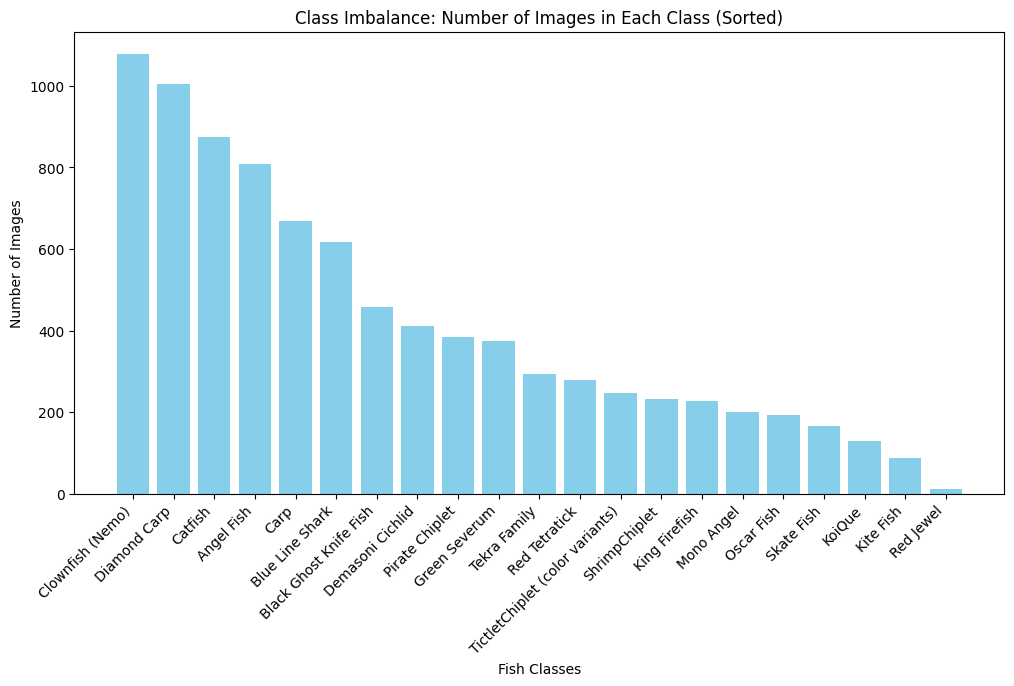

In [13]:
# Get the list of class folders
class_folders = os.listdir(path)

# Dictionary to store the count of images in each class
class_image_counts = {}

# Iterate through each class folder
for class_folder in class_folders:
    class_path = os.path.join(path, class_folder)

    # Count the number of images in the class folder
    num_images = len(os.listdir(class_path))

    # Store the count in the dictionary
    class_image_counts[class_folder] = num_images

# Sort the dictionary items by value in descending order
sorted_class_image_counts = dict(sorted(class_image_counts.items(), key=lambda item: item[1], reverse=True))

# Plotting the bar graph
plt.figure(figsize=(12, 6))
plt.bar(sorted_class_image_counts.keys(), sorted_class_image_counts.values(), color='skyblue')
plt.xlabel('Fish Classes')
plt.ylabel('Number of Images')
plt.title('Class Imbalance: Number of Images in Each Class (Sorted)')
plt.xticks(rotation=45, ha='right')
plt.show()

In [14]:
sorted_class_image_counts

{'Clownfish (Nemo)': 1079,
 'Diamond Carp': 1004,
 'Catfish': 874,
 'Angel Fish': 808,
 'Carp': 669,
 'Blue Line Shark': 617,
 'Black Ghost Knife Fish': 458,
 'Demasoni Cichlid': 410,
 'Pirate Chiplet': 384,
 'Green Severum': 374,
 'Tekra Family': 293,
 'Red Tetratick': 278,
 'TictletChiplet (color variants)': 248,
 'ShrimpChiplet': 232,
 'King Firefish': 227,
 'Mono Angel': 201,
 'Oscar Fish': 193,
 'Skate Fish': 167,
 'KoiQue': 130,
 'Kite Fish': 88,
 'Red Jewel': 11}

In [15]:
total_images = sum(class_image_counts.values())
total_classes = len(class_image_counts)
average_images_per_class = total_images / total_classes

print(f"Total Images: {total_images}")
print(f"Total Classes: {total_classes}")
print(f"Average Images per Class: {average_images_per_class:.2f}")

minority_class_names = []
# Print classes with fewer images than the average
print("Classes with fewer images than the average:")
for class_name, image_count in class_image_counts.items():
    if image_count < average_images_per_class:
        print(f"{class_name}: {image_count} images")
        minority_class_names.append(class_name)

Total Images: 8745
Total Classes: 21
Average Images per Class: 416.43
Classes with fewer images than the average:
ShrimpChiplet: 232 images
KoiQue: 130 images
Skate Fish: 167 images
Pirate Chiplet: 384 images
Red Tetratick: 278 images
Mono Angel: 201 images
Oscar Fish: 193 images
TictletChiplet (color variants): 248 images
Tekra Family: 293 images
Red Jewel: 11 images
King Firefish: 227 images
Demasoni Cichlid: 410 images
Green Severum: 374 images
Kite Fish: 88 images


In [16]:
majority_class_names = []
for class_name, image_count in class_image_counts.items():
    if image_count > 100:
        print(f"{class_name}: {image_count} images")
        majority_class_names.append(class_name)

ShrimpChiplet: 232 images
KoiQue: 130 images
Skate Fish: 167 images
Pirate Chiplet: 384 images
Red Tetratick: 278 images
Mono Angel: 201 images
Oscar Fish: 193 images
TictletChiplet (color variants): 248 images
Tekra Family: 293 images
Clownfish (Nemo): 1079 images
Catfish: 874 images
Carp: 669 images
King Firefish: 227 images
Black Ghost Knife Fish: 458 images
Blue Line Shark: 617 images
Demasoni Cichlid: 410 images
Diamond Carp: 1004 images
Green Severum: 374 images
Angel Fish: 808 images


In [17]:
minority_class_names

['ShrimpChiplet',
 'KoiQue',
 'Skate Fish',
 'Pirate Chiplet',
 'Red Tetratick',
 'Mono Angel',
 'Oscar Fish',
 'TictletChiplet (color variants)',
 'Tekra Family',
 'Red Jewel',
 'King Firefish',
 'Demasoni Cichlid',
 'Green Severum',
 'Kite Fish']

In [18]:
majority_class_names

['ShrimpChiplet',
 'KoiQue',
 'Skate Fish',
 'Pirate Chiplet',
 'Red Tetratick',
 'Mono Angel',
 'Oscar Fish',
 'TictletChiplet (color variants)',
 'Tekra Family',
 'Clownfish (Nemo)',
 'Catfish',
 'Carp',
 'King Firefish',
 'Black Ghost Knife Fish',
 'Blue Line Shark',
 'Demasoni Cichlid',
 'Diamond Carp',
 'Green Severum',
 'Angel Fish']

In [19]:
train_dir = "/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/train/"
test_dir = "/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/"

In [ ]:
walk_through_dir("/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/")

There are 3 directories and 0 images in '/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/'.
There are 21 directories and 0 images in '/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/train'.
There are 0 directories and 162 images in '/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/train/ShrimpChiplet'.
There are 0 directories and 91 images in '/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/train/KoiQue'.
There are 0 directories and 116 images in '/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/train/Skate Fish'.
There are 0 directories and 268 images in '/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/train/Pirate Chiplet'.
There are 0 directories and 194 images in '/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/train/Red Tetratick'.
There are 0 directories and 140 images in '/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/train/Mono Angel'.
There are 0 directories and 135 images in

In [20]:
# Setup data inputs
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 6109 files belonging to 21 classes.
Found 2635 files belonging to 21 classes.


In [ ]:
# Create checkpoint callback to save model for later use
checkpoint_path = "/content/drive/MyDrive/Haram Fish dataset/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)


In [21]:
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [22]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 21)                26901     
                                                             

In [24]:
 #Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes = model.fit(train_data,
                                epochs=5, # fit for 5 epochs to keep experiments quick
                                validation_data=test_data,
                                validation_steps=int(0.15 * len(test_data))) # evaluate on smaller portion of test data

Epoch 1/5
191/191 [==============================] - 1268s 6s/step - loss: 0.4808 - accuracy: 0.9180 - val_loss: 0.1055 - val_accuracy: 0.9974
Epoch 2/5
191/191 [==============================] - 98s 505ms/step - loss: 0.0547 - accuracy: 0.9971 - val_loss: 0.0511 - val_accuracy: 1.0000
Epoch 3/5
191/191 [==============================] - 92s 471ms/step - loss: 0.0285 - accuracy: 0.9985 - val_loss: 0.0378 - val_accuracy: 1.0000
Epoch 4/5
191/191 [==============================] - 84s 430ms/step - loss: 0.0180 - accuracy: 0.9992 - val_loss: 0.0208 - val_accuracy: 1.0000
Epoch 5/5
191/191 [==============================] - 76s 391ms/step - loss: 0.0128 - accuracy: 0.9997 - val_loss: 0.0213 - val_accuracy: 1.0000


In [25]:
# Evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

83/83 [==============================] - 466s 6s/step - loss: 0.0356 - accuracy: 0.9989


[0.03558989614248276, 0.9988614916801453]

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_fine_tune = model.fit(train_data,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes.epoch[-1]) # start from previous last epoch

In [ ]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_fine_tune = model.evaluate(test_data)
results_all_classes_fine_tune

In [ ]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

In [26]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take

83/83 [==============================] - 22s 239ms/step


In [27]:
# How many predictions are there?
len(pred_probs)

2635

In [28]:
# What's the shape of our predictions?
pred_probs.shape

(2635, 21)

In [29]:
# How do they look?
pred_probs[:10]

array([[9.98528481e-01, 6.68762732e-05, 2.16868109e-04, 4.33962523e-05,
        1.35786118e-04, 1.28406846e-05, 1.09382727e-05, 1.50330059e-04,
        1.10058681e-05, 1.11154850e-05, 4.69663837e-06, 7.50591937e-07,
        1.05827923e-04, 5.48311684e-04, 5.49325487e-05, 1.42861563e-05,
        1.48443469e-05, 3.74578885e-05, 2.83006352e-06, 6.40589951e-06,
        2.20186339e-05],
       [9.98410225e-01, 1.00719510e-04, 4.39466035e-04, 3.54311414e-05,
        4.44320729e-04, 8.71025622e-05, 1.81661762e-05, 7.33257548e-05,
        1.40152861e-05, 7.98043129e-06, 4.72820420e-06, 8.53839595e-07,
        9.14829725e-05, 1.57941977e-04, 1.77332604e-05, 1.08350923e-05,
        4.20213073e-05, 1.28745505e-05, 3.50095252e-06, 1.51754848e-05,
        1.21101593e-05],
       [9.97386158e-01, 2.00385635e-04, 9.49456007e-04, 2.67204814e-05,
        3.26153211e-04, 1.99691814e-04, 2.37661079e-04, 1.51599263e-04,
        4.77898866e-05, 2.18238711e-05, 1.38455307e-05, 2.33750984e-06,
        1.4656

In [30]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 21
What prediction probability sample 0 looks like:
 [9.9852848e-01 6.6876273e-05 2.1686811e-04 4.3396252e-05 1.3578612e-04
 1.2840685e-05 1.0938273e-05 1.5033006e-04 1.1005868e-05 1.1115485e-05
 4.6966384e-06 7.5059194e-07 1.0582792e-04 5.4831168e-04 5.4932549e-05
 1.4286156e-05 1.4844347e-05 3.7457889e-05 2.8300635e-06 6.4058995e-06
 2.2018634e-05]
The class with the highest predicted probability by the model for sample 0: 0


In [31]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [32]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [33]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

2635

In [34]:
# Get accuracy score by comparing predicted classes to ground truth labels
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.9988614800759014

In [35]:
# Does the evaluate method compare to the Scikit-Learn measured accuracy?
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

NameError: ignored

In [37]:
# We'll import our make_confusion_matrix function from https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py
from helper_functions import make_confusion_matrix

In [38]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.
    # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [39]:
# Get the class names
class_names = test_data.class_names
class_names[:10]

['Angel Fish',
 'Black Ghost Knife Fish',
 'Blue Line Shark',
 'Carp',
 'Catfish',
 'Clownfish (Nemo)',
 'Demasoni Cichlid',
 'Diamond Carp',
 'Green Severum',
 'King Firefish']

In [40]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [41]:
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      1.00      1.00       138
           2       1.00      1.00      1.00       186
           3       1.00      1.00      1.00       201
           4       1.00      1.00      1.00       263
           5       1.00      1.00      1.00       324
           6       1.00      1.00      1.00       123
           7       1.00      1.00      1.00       302
           8       1.00      1.00      1.00       113
           9       1.00      1.00      1.00        69
          10       1.00      0.93      0.96        27
          11       0.97      1.00      0.99        39
          12       1.00      1.00      1.00        61
          13       1.00      1.00      1.00        58
          14       1.00      1.00      1.00       116
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00        84
          17       1.00    

In [42]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 243},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 138},
 '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 186},
 '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 201},
 '4': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 263},
 '5': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 324},
 '6': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 123},
 '7': {'precision': 1.0,
  'recall': 0.9966887417218543,
  'f1-score': 0.9983416252072967,
  'support': 302},
 '8': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 113},
 '9': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 69},
 '10': {'precision': 1.0,
  'recall': 0.9259259259259259,
  'f1-score': 0.9615384615384615,
  'support': 27},
 '11': {'precision': 0.975,
  'recall': 1.0,
  'f1-score': 0.9873417721518987,
  'support': 39},
 '12': {'precision

In [43]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'Angel Fish': 1.0,
 'Black Ghost Knife Fish': 1.0,
 'Blue Line Shark': 1.0,
 'Carp': 1.0,
 'Catfish': 1.0,
 'Clownfish (Nemo)': 1.0,
 'Demasoni Cichlid': 1.0,
 'Diamond Carp': 0.9983416252072967,
 'Green Severum': 1.0,
 'King Firefish': 1.0,
 'Kite Fish': 0.9615384615384615,
 'KoiQue': 0.9873417721518987,
 'Mono Angel': 1.0,
 'Oscar Fish': 1.0,
 'Pirate Chiplet': 1.0,
 'Red Jewel': 1.0,
 'Red Tetratick': 1.0,
 'ShrimpChiplet': 1.0,
 'Skate Fish': 0.9807692307692307,
 'Tekra Family': 1.0,
 'TictletChiplet (color variants)': 1.0}

In [44]:
# Turn f1-scores into dataframe for visualization
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
0               Angel Fish       1.0
1   Black Ghost Knife Fish       1.0
19            Tekra Family       1.0
17           ShrimpChiplet       1.0
16           Red Tetratick       1.0

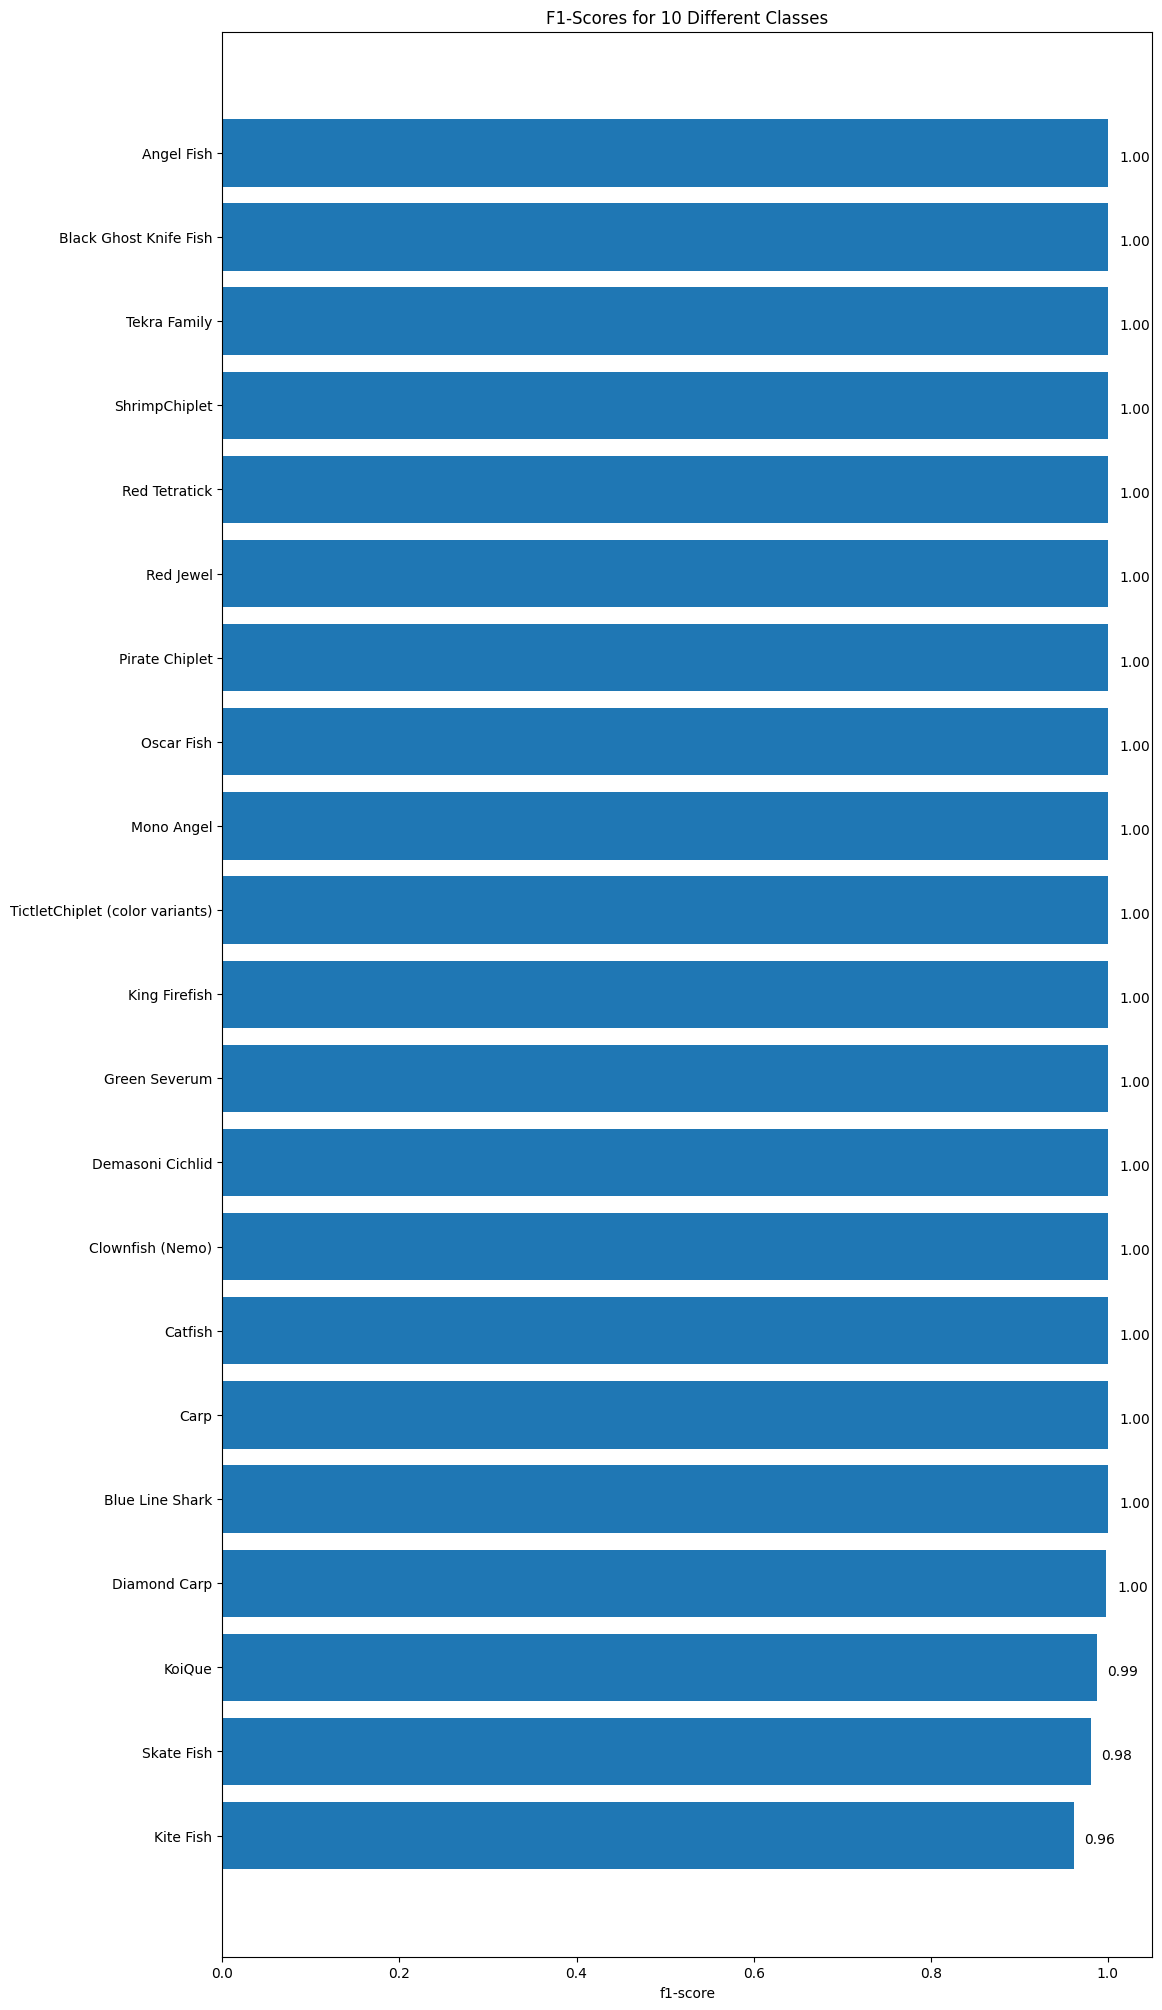

In [45]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [46]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 26ms/step


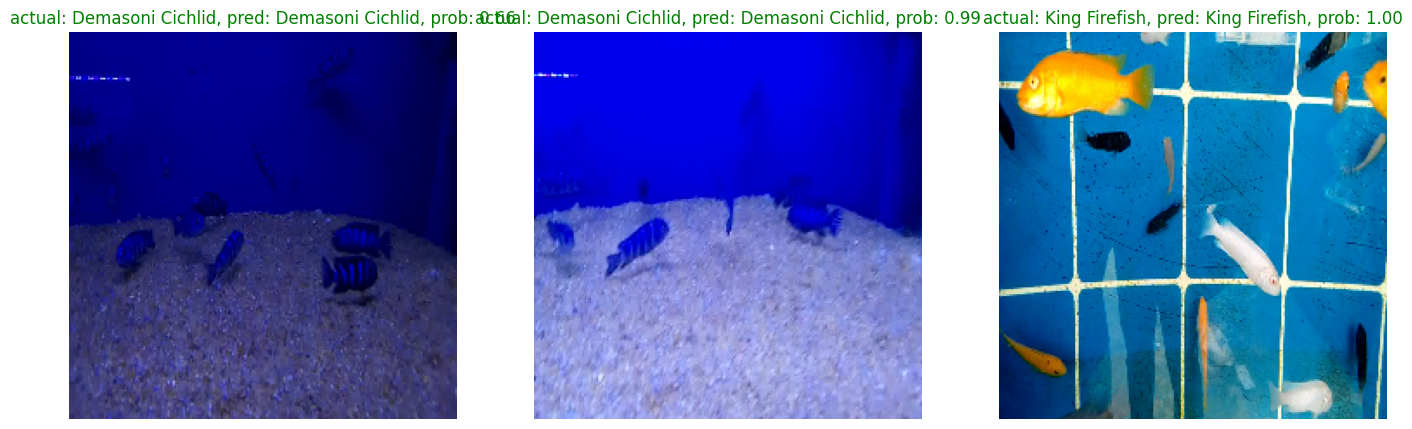

In [47]:
# Make preds on a series of random images
def make_preds(m):
  plt.figure(figsize=(17, 10))
  for i in range(3):
    # Choose a random image from a random class
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + "/" + class_name + "/" + filename

    # Load the image and make predictions
    img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
    pred_prob = m.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
    pred_class = class_names[pred_prob.argmax()] # find the predicted class

    # Plot the image(s)
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
      title_color = "g"
    else:
      title_color = "r"
    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);

make_preds(model)

1/1 [==============================] - 0s 27ms/step


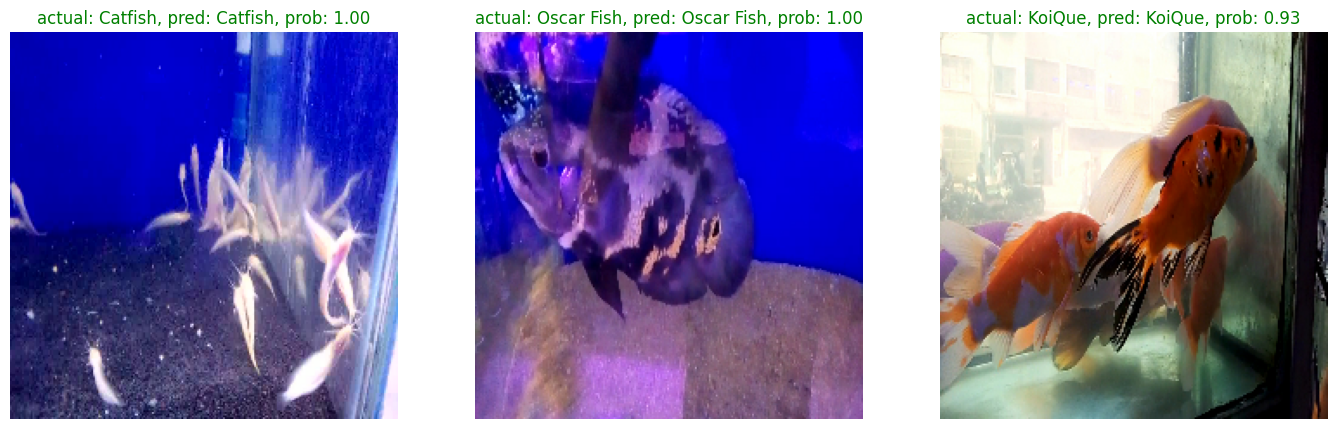

In [48]:
# Make preds on a series of random images
plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [49]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Angel Fish/00001.jpg',
 b'/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Angel Fish/00004.jpg',
 b'/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Angel Fish/00007.jpg',
 b'/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Angel Fish/00008.jpg',
 b'/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Angel Fish/00012.jpg',
 b'/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Angel Fish/00020.jpg',
 b'/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Angel Fish/00022.jpg',
 b'/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Angel Fish/00026.jpg',
 b'/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Angel Fish/00028.jpg',
 b'/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Angel Fish/00031.jpg']

In [50]:
# 2. Create a dataframe out of current prediction data for analysis
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/drive/MyDrive/Haram Fish dataset/Fi...       0       0   
1  b'/content/drive/MyDrive/Haram Fish dataset/Fi...       0       0   
2  b'/content/drive/MyDrive/Haram Fish dataset/Fi...       0       0   
3  b'/content/drive/MyDrive/Haram Fish dataset/Fi...       0       0   
4  b'/content/drive/MyDrive/Haram Fish dataset/Fi...       0       0   

   pred_conf y_true_classname y_pred_classname  
0   0.998528       Angel Fish       Angel Fish  
1   0.998410       Angel Fish       Angel Fish  
2   0.997386       Angel Fish       Angel Fish  
3   0.999221       Angel Fish       Angel Fish  
4   0.998499       Angel Fish       Angel Fish

In [51]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/drive/MyDrive/Haram Fish dataset/Fi...       0       0   
1  b'/content/drive/MyDrive/Haram Fish dataset/Fi...       0       0   
2  b'/content/drive/MyDrive/Haram Fish dataset/Fi...       0       0   
3  b'/content/drive/MyDrive/Haram Fish dataset/Fi...       0       0   
4  b'/content/drive/MyDrive/Haram Fish dataset/Fi...       0       0   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.998528       Angel Fish       Angel Fish          True  
1   0.998410       Angel Fish       Angel Fish          True  
2   0.997386       Angel Fish       Angel Fish          True  
3   0.999221       Angel Fish       Angel Fish          True  
4   0.998499       Angel Fish       Angel Fish          True

In [52]:
# 4. Get the top wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
1962  b'/content/drive/MyDrive/Haram Fish dataset/Fi...      10      18   
1968  b'/content/drive/MyDrive/Haram Fish dataset/Fi...      10      18   
1531  b'/content/drive/MyDrive/Haram Fish dataset/Fi...       7      11   

      pred_conf y_true_classname y_pred_classname  pred_correct  
1962   0.856987        Kite Fish       Skate Fish         False  
1968   0.607005        Kite Fish       Skate Fish         False  
1531   0.457252     Diamond Carp           KoiQue         False

In [53]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

<Figure size 1500x1000 with 0 Axes>

In [54]:
# Define the directory where your images are located in Google Drive
image_directory = "/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Carp"

# List all image file paths in the specified directory
custom_food_images = [os.path.join(image_directory, img_path) for img_path in os.listdir(image_directory)]

# Print the list of image file paths
print(custom_food_images)

['/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Carp/VID_20230827_163311-87 [MConverter.eu].jpg', '/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Carp/VID_20230827_163311-524 [MConverter.eu].jpg', '/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Carp/VID_20230827_163311-620 [MConverter.eu].jpg', '/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Carp/VID_20230827_163311-128 [MConverter.eu].jpg', '/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Carp/VID_20230827_163311-421 [MConverter.eu].jpg', '/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Carp/VID_20230827_163311-581 [MConverter.eu].jpg', '/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Carp/VID_20230827_163311-79 [MConverter.eu].jpg', '/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_Self/test/Carp/VID_20230827_163311-350 [MConverter.eu].jpg', '/content/drive/MyDrive/Haram Fish dataset/Fish_Splitted_

In [55]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

Output hidden; open in https://colab.research.google.com to view.

In [56]:
plt.plot(history_all_classes_fine_tune.history['loss'], label='loss')
#plt.plot(history_all_classes_fine_tune.history['val_loss'], label='val_loss')
plt.legend()

NameError: ignored

In [ ]:
plt.plot(history_all_classes_fine_tune.history['accuracy'], label='acc')
#plt.plot(history_all_classes_fine_tune.history['val_accuracy'], label='val_acc')
plt.legend()

In [57]:
model_name = 'fyp_haram_model.h5'
model.save(model_name, save_format='h5')
model.save_weights('fyp_haram_model_weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [58]:
loaded_model = load_model("fyp_haram_model.h5")

In [59]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 21)                26901     
                                                             

1/1 [==============================] - 0s 29ms/step


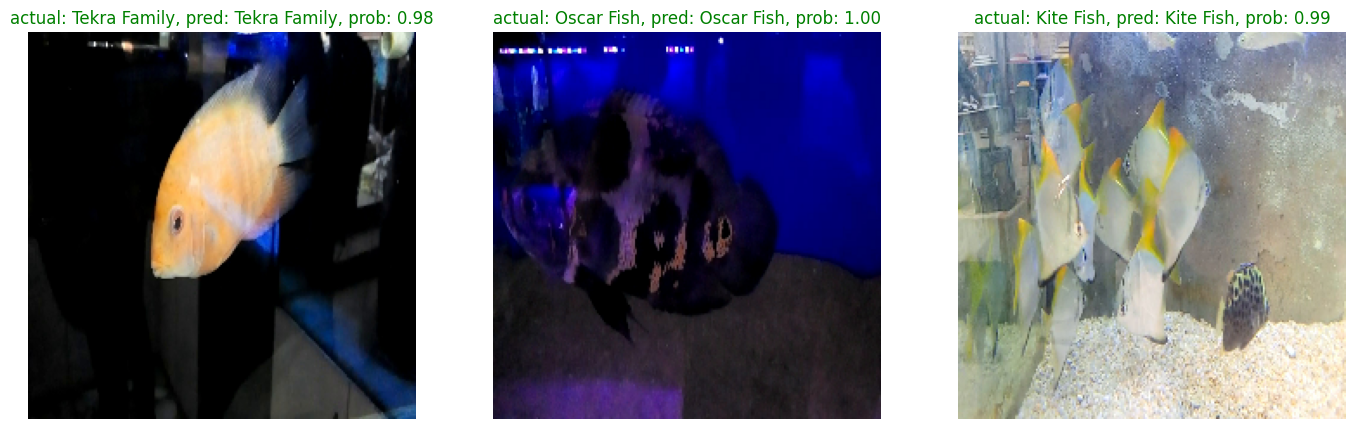

In [60]:
make_preds(loaded_model)

In [61]:
loaded_model1 = loaded_model
loaded_model1.load_weights("/content/fyp_haram_model_weights.h5")

1/1 [==============================] - 0s 25ms/step


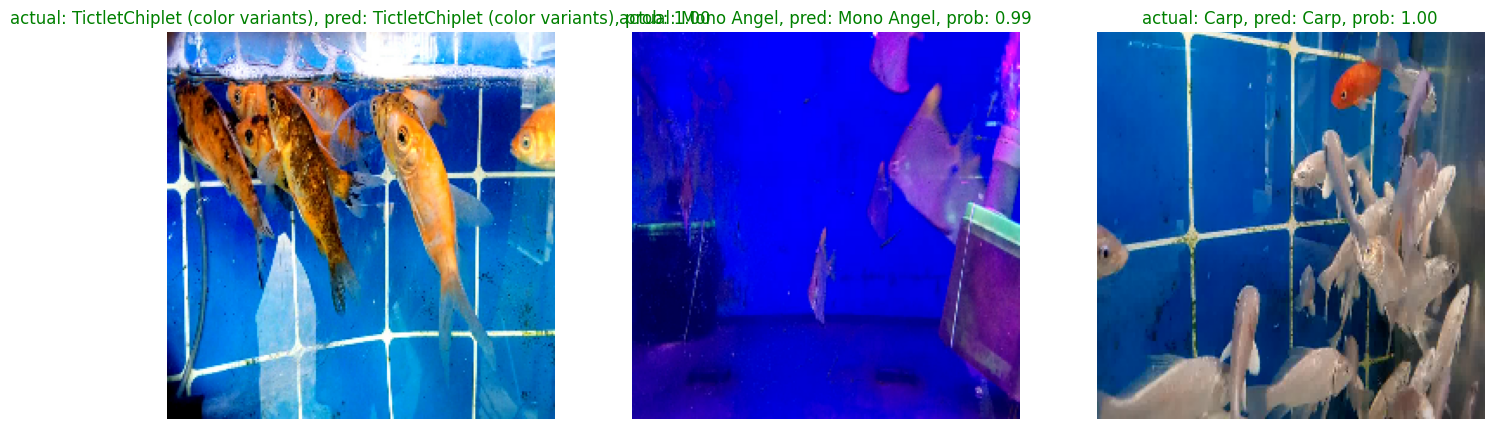

In [62]:
make_preds(loaded_model1)

In [63]:
# Make predictions with model
pred_probs = loaded_model1.predict(test_data, verbose=1) # set verbosity to see how long it will take

83/83 [==============================] - 19s 216ms/step


In [64]:
# How many predictions are there?
len(pred_probs)

2635

In [65]:
# What's the shape of our predictions?
pred_probs.shape

(2635, 21)

In [66]:
!cp /content/fyp_haram_model.h5 '/content/drive/MyDrive/Colab Notebooks/Models'
!cp /content/fyp_haram_model_weights.h5 '/content/drive/MyDrive/Colab Notebooks/Models'

In [67]:
test_data.class_names

['Angel Fish',
 'Black Ghost Knife Fish',
 'Blue Line Shark',
 'Carp',
 'Catfish',
 'Clownfish (Nemo)',
 'Demasoni Cichlid',
 'Diamond Carp',
 'Green Severum',
 'King Firefish',
 'Kite Fish',
 'KoiQue',
 'Mono Angel',
 'Oscar Fish',
 'Pirate Chiplet',
 'Red Jewel',
 'Red Tetratick',
 'ShrimpChiplet',
 'Skate Fish',
 'Tekra Family',
 'TictletChiplet (color variants)']